In [1]:
import pandas as pd
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt

os.getcwd()

DATA_PATH = Path("../data/raw/train.csv")
DATA_PATH, DATA_PATH.exists()

(PosixPath('../data/raw/train.csv'), True)

In [2]:
PROJECT_ROOT = Path("..").resolve()  # parent of notebooks/ → /app

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added to sys.path:", PROJECT_ROOT)


Project root added to sys.path: /app


### Load the dataset

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Define the label mapping

In [4]:
TOXIC_COLS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def map_row_to_label(row) -> int:
    # No toxic labels at all → safe
    if row[TOXIC_COLS].sum() == 0:
        return 0  # safe
    
    # Identity-based hate: give it its own class
    if row["identity_hate"] == 1:
        return 2  # hate
    
    # All other toxic cases
    return 1      # toxic

df["label"] = df.apply(map_row_to_label, axis=1)
df[["label"]].value_counts().sort_index()


label
0        143346
1         14820
2          1405
Name: count, dtype: int64

In [5]:
ID2LABEL = {0: "safe", 1: "toxic", 2: "hate"}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

df["label_name"] = df["label"].map(ID2LABEL)

df["label_name"].value_counts(), df["label_name"].value_counts(normalize=True)


(label_name
 safe     143346
 toxic     14820
 hate       1405
 Name: count, dtype: int64,
 label_name
 safe     0.898321
 toxic    0.092874
 hate     0.008805
 Name: proportion, dtype: float64)

### Check examples per class

In [6]:
for label_id, label_name in ID2LABEL.items():
    print(f"\n### Examples for {label_name.upper()} ({label_id})")
    display(
        df[df["label"] == label_id][["comment_text", "label_name"]]
        .sample(5, random_state=42)
    )



### Examples for SAFE (0)


,comment_text,label_name
46733,"""\n\nOh, don't worry about me, Sandstein. I'm ...",safe
110326,Are you trying to dispute that fact?,safe
76687,SWOT analysis \n\nThis source – Align Technolo...,safe
36231,"cover \n\nso, do we want a current or older co...",safe
21514,P.S. It's probably worth setting up a template...,safe



### Examples for TOXIC (1)


,comment_text,label_name
64975,Your content is jerky. Please stop or I will ...,toxic
124654,Oh really??? 15% Huh? wow who knew that 15% wa...,toxic
27849,You are a vandal \n\nI do no such vandalism. ...,toxic
14644,SlimVirgin \n\nYou've been reported as a suspe...,toxic
116569,"""*E-dog, on another page, you wrote: \n\nThank...",toxic



### Examples for HATE (2)


,comment_text,label_name
124316,REDIRECT Talk:Bolivian chinchilla rat,hate
57276,TO SITUSH(PAKISTANI PIG) \n\nWhat is your pr...,hate
76164,Bloody asshole \n\nYou are a bloody asshole an...,hate
76509,Fuck off you right wing nazi scum. BTW your cr...,hate
111388,MUST BE A ASS BUDDY OF CRUISERFAGGOT,hate


### check comment length distribution

In [7]:
df["text_length"] = df["comment_text"].astype(str).str.len()
df["text_length"].describe()


count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64

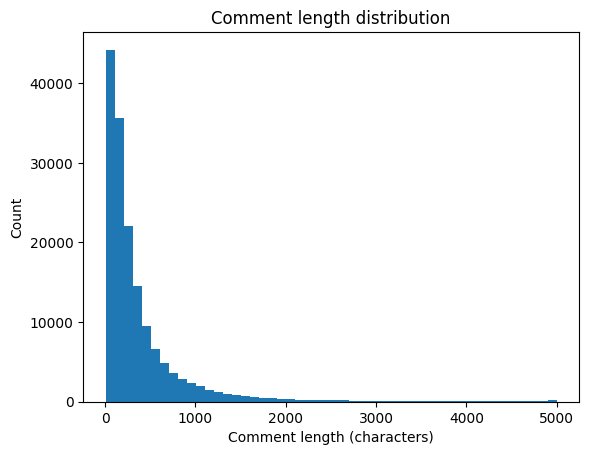

In [8]:
plt.hist(df["text_length"], bins=50)
plt.xlabel("Comment length (characters)")
plt.ylabel("Count")
plt.title("Comment length distribution")
plt.show()


### Train/val split and save processed CSVs

In [9]:
from sklearn.model_selection import train_test_split
from pathlib import Path

use_df = df[["comment_text", "label"]].copy()

train_df, val_df = train_test_split(
    use_df,
    test_size=0.1,
    random_state=42,
    stratify=use_df["label"],
)

train_df.shape, val_df.shape


((143613, 2), (15958, 2))

In [10]:
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

train_df.to_csv(processed_dir / "train.csv", index=False)
val_df.to_csv(processed_dir / "val.csv", index=False)

processed_dir, list(processed_dir.iterdir())


(PosixPath('../data/processed'),
 [PosixPath('../data/processed/val.csv'),
  PosixPath('../data/processed/train.csv')])

### sanity-check

In [11]:
from src.datasets import load_split, get_label_mappings

train_ds = load_split("train")
val_ds = load_split("val")

len(train_ds), len(val_ds), get_label_mappings()


(143613,
 15958,
 ({0: 'safe', 1: 'toxic', 2: 'hate'}, {'safe': 0, 'toxic': 1, 'hate': 2}))